In [202]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import warnings
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings


filterwarnings("ignore")


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [203]:
df = pd.read_excel("/Users/dokig/Desktop/amazon.xlsx")

In [204]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [205]:
df["Review"] = df["Review"].str.lower()

In [206]:
## Noktalama işaretleri çıkarma
df["Review"] = df["Review"].str.replace("[^\w\s]", " ")

In [207]:
## Sayısal ifadeleri çıkarma
df["Review"] = df["Review"].str.replace("\d", " ")

In [208]:
from nltk.corpus import stopwords

sw = stopwords.words("english")
df["Review"] = df["Review"].apply(lambda x: " ".join( x for x in str(x).split() if x not in sw))

In [209]:
temp_df = pd.Series(" ".join(df["Review"]).split).value_counts() 

In [210]:
drops = temp_df[temp_df<1000]

In [211]:
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in drops))


In [212]:
import nltk
nltk.download("wordnet")
df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dokig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [213]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panel mis-matched.
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...
4,5,0,Wow great purchase,great bang buck can't believe quality material...


In [214]:
tf_df = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [215]:
tf_df.columns = ["words", "tf"]

In [216]:
tf_df.head()

,words,tf
0,happy,171.00
1,good,454.00
2,quality,609.00
3,material,398.00
4,however,36.00


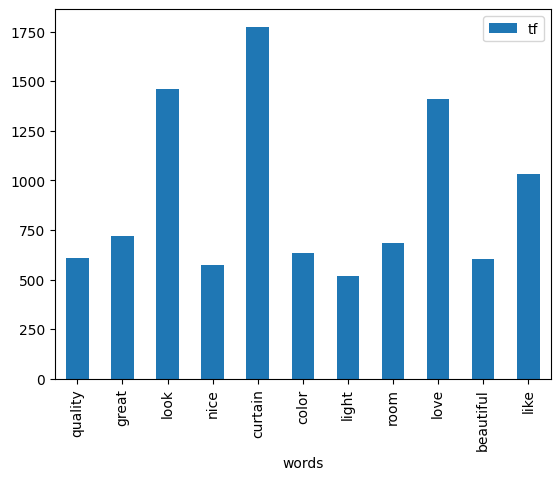

In [217]:
tf_df[tf_df["tf"]>500].plot.bar(x="words", y="tf")
plt.show()

In [218]:
text = " ".join(i for i in df.Review)

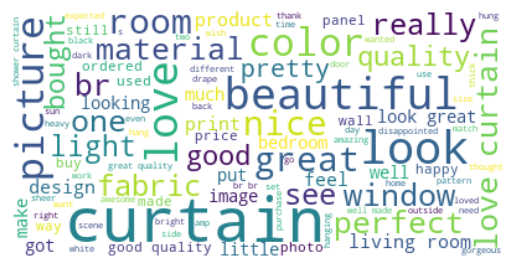

In [219]:
wordcloud = WordCloud(max_font_size=50,max_words=100,background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [220]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dokig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [221]:
df["Polarity_scores"] =df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [222]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg" )

In [223]:
#from sklearn.preprocessing import LabelEncoder
#df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [224]:
X = df["Review"]
y = df["sentiment_label"]

In [225]:
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

In [226]:
from sklearn.metrics import accuracy_score, log_loss

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [228]:
## n-gram frekans

x_vectorized = TfidfVectorizer().fit(X_train)


In [229]:
X_train_idf = x_vectorized.transform(X_train)


In [230]:
X_test_idf = x_vectorized.transform(X_test)

In [231]:
### tfidf için   ( Tf-IDF)



lgbm_model = LGBMClassifier( random_state=19, verbose=-1)

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500,600],
               "colsample_bytree": [0.5, 0.7, 1],
                'num_leaves': [10]
             }


lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train_idf, y_train)


final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X_train_idf, y_train)

from sklearn.metrics import accuracy_score, log_loss


print(f"tfidf için : {cross_val_score(final_model,X_test_idf, y_test,cv=5, n_jobs=-1).mean()}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
tfidf için : 0.8888179969496696


In [232]:
random_comment = pd.Series(df["Review"].sample(1).values)
random_comment

0    sheer material feel like shower curtain
dtype: object

In [233]:
new_vector = TfidfVectorizer().fit(X_train)
random_comment = new_vector.transform(random_comment)


In [234]:
final_model.predict(random_comment)

array(['pos'], dtype=object)

In [235]:
## n_gram tfidf vectorizer için ( count vectorizer)

X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size = 0.30)

lgbm_model = LGBMClassifier( random_state=19, verbose=-1)

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500,600],
               "colsample_bytree": [0.5, 0.7, 1],
                'num_leaves': [10]
             }


lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)


final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X_train, y_train)

from sklearn.metrics import accuracy_score, log_loss

print(f" tfidf n_gram vectorizer için : {cross_val_score(final_model,X_test, y_test,cv=5, n_jobs=-1).mean()}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


 tfidf n_gram vectorizer için : 0.8515437332202911
